# Standar classification
In a standard classification task with an underlying data distribution  $D$ over pairs of examples $x \in IR^d $ and corresponding labels $y$.
We assume that we are given a suitable loss function $L(\theta, x, y)$, for instance the cross-entropy loss for a neural network. Our goal then is to find model parameters $\theta$ that minimize the risk $E_{(x,y)D}[L(x, y, \theta)]$.

# Defining adversarial attack and adversarial training 


## Atack Model
For each data point $x$, we introduce a set of allowed perturbations $S \in R^d$ that formalizes the manipulative power of the adversary. In image classification, we choose $S$ so that it captures perceptual similarity between images. For instance,the $ℓ_\infty$-ball around $x$ has recently been studied as a natural notion for adversarial perturbations. Then we search to optimize the following:
 $$\max_{\delta \in S} L(\theta, x+\delta,y)$$

 ## Defense Model
we modify the definition of population risk ED[L] by incorporating the above adversary.
Instead of feeding samples from the distribution $D$ directly into the loss $L$, we allow the adversary
to perturb the input first. This gives rise to the following **saddle point problem**, which is our central
object of study
  $$\min_{\theta} \mathbb{E_{(x,y)}}_D[\max_{\delta \in S} L(\theta, x+\delta,y)]$$

The inner maximization problem aims to find
an adversarial version of a given data point x that achieves a high loss. This is precisely the problem
of attacking a given neural network. On the other hand, the goal of the outer minimization problem
is to find model parameters so that the “adversarial loss” given by the inner attack problem is
minimized. This is precisely the problem of training a robust classifier using adversarial training
techniques

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


In [2]:
width = 100
height = 100

In [3]:
#DATA
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
X_train , X_test = X_train.astype(np.float32) , X_test.astype(np.float32)
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Y_train = keras.utils.np_utils.to_categorical(Y_train, len(labels)) #tf.keras.utils.to_categorical(y_train, dtype='float32')
Y_test = keras.utils.np_utils.to_categorical(Y_test, len(labels))

x_train = tf.data.Dataset.from_tensor_slices(X_train)
x_test = tf.data.Dataset.from_tensor_slices(X_test)
y_train = tf.data.Dataset.from_tensor_slices(Y_train)
y_test = tf.data.Dataset.from_tensor_slices(Y_test)

train_ds = tf.data.Dataset.zip((x_train,y_train))
test_ds = tf.data.Dataset.zip((x_test,y_test))
train_ds = train_ds.batch(128)
test_ds = test_ds.batch(1)

In [4]:
def preprocess(image):
    image = tf.image.resize(image, (width, height))
    image = tf.keras.applications.vgg16.preprocess_input(image)
    return image

def gaussian_blur(img, kernel_size=11, sigma=5):
    def gauss_kernel(channels, kernel_size, sigma):
        ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
        xx, yy = tf.meshgrid(ax, ax)
        kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels])
        return kernel

    gaussian_kernel = gauss_kernel(tf.shape(img)[-1], kernel_size, sigma)
    gaussian_kernel = gaussian_kernel[..., tf.newaxis]

    return tf.nn.depthwise_conv2d(img, gaussian_kernel, [1, 1, 1, 1],
                                  padding='SAME', data_format='NHWC')

def giveModel():
    vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(width, height,3),)
    vgg16.trainable = False
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Lambda(preprocess))
    model.add(vgg16)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer='adam',loss=loss_object, metrics=['accuracy'])
    return model


In [5]:
model = giveModel()
model.fit(train_ds,validation_data=test_ds, epochs=2)

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
391/391 [==============================] - ETA: 0s - loss: 0.7555 - accuracy: 0.7529WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001FA42E080D0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

In [6]:
model.save('model_weights')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: model_weights\assets


13.0
255.0
(1, 32, 32, 3)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
cat


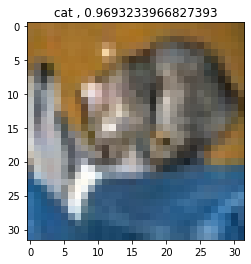

In [7]:
for i, (image, label) in test_ds.take(1).enumerate():
    print(np.min(image))
    print(np.max(image))
    print(image.shape)
    y_pred = model.predict(image)
    prob = np.max(y_pred)
    arg = tf.argmax(y_pred, axis=1)[0]
    #print(arg)
    #print((y_pred))
    print(labels[tf.argmax(label, axis=1)[0]])
    label_pred = labels[arg]
    plt.figure()
    #plt.imshow(tf.cast(image[0], tf.uint8))
    plt.imshow(image[0]/255.0)
    plt.title("{} , {}".format(label_pred, prob))


## FGSM
Fast Gradient Sign Method (FGSM)—This attack computes the
gradient of the model’s output with respect to its input. It then
perturbs examples in that direction. The computational efficiency
of this attack comes at the expense of it introducing large perturbations that affect the entire input. This attack is not targeted towards
a particular class
$$x + \epsilon sgn(\triangledown_xL(\theta, x, y))$$

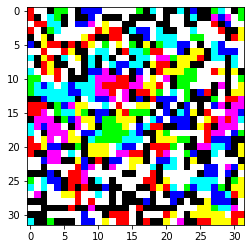

In [9]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
def get_sign_gradient(input_image, input_label):
    #input_image = preprocess(input_image)
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

for image, label in  test_ds.take(1):
    perturbations = get_sign_gradient(image, label)
    plt.imshow(perturbations[0]*0.5+0.5); # To change [-1, 1] to [0,1]

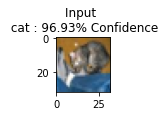

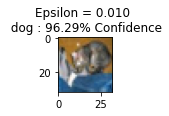

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


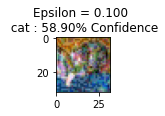

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


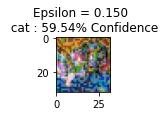

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


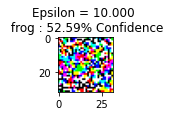

In [10]:
def display_images(image, description):
    # _, label, confidence = get_imagenet_label(model.predict(image))
    y_pred = model.predict(image*255.0)
    confidence = np.max(y_pred)
    arg = tf.argmax(y_pred, axis=1)[0]
    label = labels[arg]
    plt.figure(figsize=(1,1))
    #print(np.min(image[0]))
    #plt.imshow(tf.cast(image[0], tf.uint8))
    plt.imshow(image[0])
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
    plt.show()

epsilons = [0, 0.01, 0.1, 0.15,10]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    for image, label in test_ds.take(1):
        image=image/255.0
        adv_x = image + eps*perturbations
        adv_x = tf.clip_by_value(adv_x, -1, 1)
        #adv_x = (adv_x*0.5+0.5)
        #print(np.min(adv_x))
        display_images(adv_x, descriptions[i])

# BIM


In [8]:
def BIM(input_image, input_label, alpha):
    for i in range(step):
        with tf.GradientTape() as tape:
            tape.watch(input_image)
            prediction = model(input_image)
            loss = loss_object(input_label, prediction)
        gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    signed_grad = (signed_grad*0.5+0.5)*255.0
    adv_x = input_image + alpha*signed_grad
    adv_x = tf.clip_by_value(adv_x, 0, 255)
    y_pred = model.predict(adv_x*255.0)
    confidence = np.max(y_pred)
    arg = tf.argmax(y_pred, axis=1)[0]
    return signed_grad

# Deep Fool

In [11]:
def im_gradient_k(input_image, model, k):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = prediction[k]
    gradient = tape.gradient(loss, input_image)
    return gradient, loss

def deepfool(image, model, max_iter):
    label = model.predict(image)
    num_class = label.shape[0]
    label = tf.argmax(label)
    label_temp = tf.identity(label)
    image_temp = tf.identity(image)
    w = tf.zeros_like(image)
    i = 0
    r = tf.zeros_like(image)
    while (label == label_temp or i == max_iter):
        im_grad, im_pred = im_gradient_k(image_temp, model, label)
        pert = np.inf
        l_hat = 0
        r_i = tf.zeros_like(image)
        for k in range(num_class):
            if k == label:
                continue
            k_grad, k_pred = im_gradient_k(image_temp, model, k)
            w_k = k_grad - im_grad
            f_k = k_pred - im_pred
            pert_k = abs(f_k) / np.linalg.norm(tf.reshape(w_k, [-1]))
            if pert_k < pert:
                pert = pert_k
                l_hat = k
                w = w_k
        r_i = (pert) * w / np.linalg.norm(w)
        r += r_i
        image_temp += r
        label_temp = tf.argmax(model(image_temp))
        i += 1
    return r

# Carlini

# Natural noise robustness

In [18]:
#data_augmentation = tf.keras.Sequential([
#  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
#])
data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=90,
    brightness_range=[0.2, 1.7],
    #zoom_range=[-1.5, 1.5],
    #channel_shift_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    #preprocessing_function=preprocess,
    #validation_split=0.2,
)

In [19]:
it = data_augmentation.flow(X_train,Y_train, batch_size=1)
X_aug_train = np.zeros((X_train.shape[0]*2,X_train.shape[1],X_train.shape[2],X_train.shape[3]))
Y_aug_train = np.zeros((Y_train.shape[0]*2,Y_train.shape[1]))
X_aug_train[:X_train.shape[0]] = X_train.astype('float32')
Y_aug_train[:Y_train.shape[0]] = Y_train.astype('float32')
for i in range(X_train.shape[0],X_train.shape[0]*2):
    batch,y = it.next()
    Y_aug_train[i] = y
    X_aug_train[i] = batch[0].astype('float32')


In [20]:
it = data_augmentation.flow(X_test,Y_test, batch_size=1)
X_aug_test = np.zeros((X_test.shape[0]*2,X_test.shape[1],X_test.shape[2],X_test.shape[3]))
Y_aug_test = np.zeros((Y_test.shape[0]*2,Y_test.shape[1]))
X_aug_test[:X_test.shape[0]] = X_test.astype('float32')
Y_aug_test[:Y_test.shape[0]] = Y_test.astype('float32')
for i in range(X_test.shape[0],X_test.shape[0]*2):
    batch,y = it.next()
    Y_aug_test[i] = y
    X_aug_test[i] = batch[0].astype('float32')


In [22]:
x_train = tf.data.Dataset.from_tensor_slices(X_aug_train)
y_train = tf.data.Dataset.from_tensor_slices(Y_aug_train)

x_train = tf.data.Dataset.from_tensor_slices(X_aug_train)
x_test = tf.data.Dataset.from_tensor_slices(X_aug_test)
y_train = tf.data.Dataset.from_tensor_slices(Y_aug_train)
y_test = tf.data.Dataset.from_tensor_slices(Y_aug_test)

train_ds = tf.data.Dataset.zip((x_train,y_train))
test_ds = tf.data.Dataset.zip((x_test,y_test))
train_ds = train_ds.batch(128)
test_ds = test_ds.batch(1)

In [28]:
#model = giveModel()
model.fit(train_ds,validation_data=test_ds, epochs=20)   

Epoch 1/20
782/782 [==============================] - 159s 203ms/step - loss: 0.7937 - accuracy: 0.7245 - val_loss: 0.7691 - val_accuracy: 0.7358
Epoch 2/20
782/782 [==============================] - 159s 203ms/step - loss: 0.7927 - accuracy: 0.7234 - val_loss: 0.7662 - val_accuracy: 0.7361
Epoch 3/20
782/782 [==============================] - 157s 200ms/step - loss: 0.7959 - accuracy: 0.7236 - val_loss: 0.7671 - val_accuracy: 0.7359
Epoch 4/20
782/782 [==============================] - 157s 201ms/step - loss: 0.7900 - accuracy: 0.7225 - val_loss: 0.7650 - val_accuracy: 0.7361
Epoch 5/20
782/782 [==============================] - 157s 201ms/step - loss: 0.7911 - accuracy: 0.7245 - val_loss: 0.7649 - val_accuracy: 0.7369
Epoch 6/20
782/782 [==============================] - 157s 200ms/step - loss: 0.7901 - accuracy: 0.7247 - val_loss: 0.7654 - val_accuracy: 0.7358
Epoch 7/20
782/782 [==============================] - 157s 200ms/step - loss: 0.7890 - accuracy: 0.7252 - val_loss: 0.7641 -

In [29]:
model.save('model_weights_nat_noise')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: model_weights_nat_noise\assets
